In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr,spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from statsmodels.api import Logit
import xgboost as xgb
# from imblearn.over_sampling import SMOTE
import random

import holidays
import requests
from time import sleep
from shutil import copyfile
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [3]:
# # To find out where the pyspark
# import findspark
# findspark.init()

# # Creating Spark Context
# from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import StringType, IntegerType, DecimalType, DoubleType

In [4]:
from pyspark.ml.feature import VectorAssembler,CountVectorizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
"""SimpleApp.py"""
spark = SparkSession.builder.appName("FirstSparkApp").getOrCreate()

In [28]:
df_spark = spark.read\
    .format("com.databricks.spark.csv")\
    .option("header", "true") \
    .option("mode", "DROPMALFORMED")\
    .option("inferSchema", "true")\
    .load('/home/arditto_trianggada3/Workspace/ds-ovo-test/dataset/spark_df/df_agg1')

In [7]:
df1 = df_spark.limit(10).toPandas()

In [8]:
df1.head(5)

,hack_license,trip_num,passenger_count_min,passenger_count_median,passenger_count_max,pickup_longitude_min,pickup_latitude_min,pickup_longitude_max,pickup_latitude_max,dropoff_longitude_min,dropoff_latitude_min,dropoff_longitude_max,dropoff_latitude_max,fare_amount_sum,tip_amount_sum,tip_amount_count,surcharge_sum,surcharge_count,pickup_to_dropoff_local_list,pickup_to_dropoff_local_set,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,trip_late_night_sum,trip_night_sum,trip_time_in_secs_min,trip_time_in_secs_median,trip_time_in_secs_max,trip_time_in_secs_sum,trip_dist_euclidean_min,trip_dist_euclidean_median,trip_dist_euclidean_max,trip_dist_euclidean_sum,pickup_time_in_secs_min,pickup_time_in_secs_median,pickup_time_in_secs_max,pickup_time_in_secs_sum,pickup_dist_euclidean_min,pickup_dist_euclidean_median,pickup_dist_euclidean_max,pickup_dist_euclidean_sum,pickup_hour,pickup_hour_median,pickup_hour_max,work_time_in_secs
0,001916B0A5713FF05D936EFF82EEBA02,17,1,1,1,-74.007591,40.716557,-73.865509,40.779381,-74.008041,40.681931,-73.889580,40.807598,241.0,30.88,11,13.5,17,"[nan_New York, New York_New York, New York_New...","[New York_New York, nan_New York, nan_nan]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,3,2,1,1,7,13,120,660,2280,13920,0.002960,0.024471,0.128095,0.735419,60,120,2460,9120,0.000208,0.001903,0.127522,0.335225,17,19,23,23040
1,006114F940CB87B3ABDCE9BF6DF6FCC4,6,1,1,1,-73.983192,40.744667,-73.954529,40.776268,-73.982628,40.744312,-73.950111,40.800922,46.5,7.60,4,3.0,6,"[New York_New York, New York_New York, New Yor...",[New York_New York],3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,120,300,840,2520,0.006816,0.009512,0.031274,0.110856,60,60,5820,7860,0.000572,0.000871,0.045157,0.056383,0,0,23,10380
2,0080BF52B83308D6C765F4D18B409303,15,1,1,1,-74.006287,40.645226,-73.776749,40.761871,-74.007698,40.724792,-73.864960,40.770424,186.0,26.93,10,0.0,0,"[nan_New York, New York_New York, New York_New...","[New York_New York, nan_New York, New York_nan]",0,0,0,0,0,0,0,0,1,2,4,2,4,2,0,0,0,0,0,0,0,0,0,0,0,120,720,3540,12540,0.006830,0.015444,0.219996,0.561000,60,180,3240,6060,0.000161,0.003676,0.009685,0.059836,8,11,13,18600
3,00A1DE03204248F82D05A0849F7182FD,18,1,1,4,-74.008278,40.695362,-73.874474,40.779915,-74.026054,40.621658,-73.861061,40.840637,257.5,20.75,9,8.5,17,"[New York_New York, New York_nan, nan_nan, nan...","[New York_New York, nan_New York, nan_nan, New...",3,0,0,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,3,3,2,2,18,0,184,607,1631,13940,0.004393,0.027034,0.170511,0.861998,104,643,50694,72555,0.000004,0.011244,0.139851,0.583241,0,20,23,86504
4,00A84F2983BCE93E943137C590D631D7,14,1,1,1,-74.005539,40.708080,-73.872787,40.790768,-74.008263,40.695087,-73.902351,40.787533,121.0,16.70,7,8.5,14,"[New York_New York, New York_New York, New Yor...","[New York_New York, nan_nan, New York_nan]",3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,4,0,0,4,11,7,65,463,1538,7046,0.005352,0.023390,0.044567,0.313024,39,258,64767,78988,0.000202,0.003260,0.080266,0.203560,0,20,23,86040


In [16]:
class labelEnc():
    """
    Label Encoding
    """
    def __init__(self, categorical_features):
        self.key = categorical_features
        self.enc = [LabelEncoder() for c in categorical_features]
      
    def fit(self,X, y=None):
        y = np.array(X)
        self.categorical_feat_classes = {}
        for i in range(len(self.key)):
            c = self.key[i]
            self.enc[i] = self.enc[i].fit(y[:,c])
            self.categorical_feat_classes[c] = self.enc[i].classes_
        return self
      
    def transform(self,X):
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
      
    def fit_transform(self,X, y=None):
        self.fit(X,y)
        y = np.array(X)
        for i in range(len(self.key)):
            c = self.key[i]
            y[:,c] = self.enc[i].transform(y[:,c])
        return y
    
class oneHotEnc():
    """
    One Hot Encoding
    """
    def __init__(self, categorical_features, fit_onehot):
        self.key = categorical_features
        self.enc = fit_onehot.set_params(categorical_features=categorical_features)

    def fit(self, X, y=None):
        if len(self.key)>0:
            #global categorical_onehot_idx,categorical_onehot_nval 
            self.enc = self.enc.fit(X,y)
            categorical_onehot_idx = self.enc.feature_indices_
            categorical_onehot_nval = self.enc.n_values_
            self.categorical_onehot_idx = categorical_onehot_idx
            self.categorical_onehot_nval = categorical_onehot_nval
        return self

    def transform(self, X):
        if len(self.key)>0:
            y = self.enc.transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        else:
            y=X
        return y
      
    def fit_transform(self,X, y=None):
        if len(self.key)>0:
            y = self.fit(X,y).transform(X)
            y = y if type(y)==np.ndarray else y.toarray()
        return y

def getColnames(le,onehotenc,df):
    if len(onehotenc.key)>0:
        categorical_onehot_idx = onehotenc.enc.feature_indices_
        categorical_onehot_nval = onehotenc.enc.n_values_
        colname = []
        k=0
        for i in categorical_onehot_idx[:-1]:
            feat = list_col_cat[k]
            for j in range(categorical_onehot_nval[k]):
                val = le.categorical_feat_classes[le.key[k]][j]
                colname.append("{}_{}".format(feat,val))
            k+=1
        lcol_num = [x for x in df.dtypes.index.values if not(x in list_col_cat)]
        for i in lcol_num:
            colname.append("{}".format(i))
    else:
        colname = df.columns.values
    return colname

In [81]:
## Save model
class bst_models():
  
  def __init__(self,colname, score_method="mean"):
    self.model = []
    self.colname = colname
    self.score_method = score_method
  
  def add_model(self, model):
    self.model.append(model)
    return self
  
  def predict(self,X):
    d = xgb.DMatrix(X,feature_names=self.colname)
    preds=[]
    for m in self.model:
      pred = m.predict(d)
      preds.append(list(pred))
      
    K = len(preds)
    nrow = len(preds[0])
    self.K = K
    self.nrow = nrow
    pred = []
    for i in range(nrow):
      sum1=0
      for j in range(K):
        if self.score_method == "max":
          sum1 = max(sum1, preds[j][i])
        else:
          sum1+=preds[j][i]
      if self.score_method == "max":
        pred.append(sum1)
      else:
        pred.append(sum1/K)
      
    return pd.Series(pred)
  
  def get_importances(self):
    imp = dict()
    cols = self.model[0].feature_names
    for col in cols:
      imp1=0
      k1 = 0
      for j in range(self.K):
        try:
          imp1+=self.model[j].get_score()[col]
        except (KeyError):
          pass
        k1 += 1
      imp[col] = imp1 / k1
    imp = pd.Series(imp).sort_values(ascending=False)
    return imp


In [67]:
df = df_spark.toPandas()

In [68]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

pickup_time_in_secs_min         0.015589
pickup_dist_euclidean_sum       0.015589
pickup_dist_euclidean_max       0.015589
pickup_dist_euclidean_median    0.015589
pickup_dist_euclidean_min       0.015589
pickup_time_in_secs_sum         0.015589
pickup_time_in_secs_max         0.015589
pickup_time_in_secs_median      0.015589
pickup_hour_0                   0.000000
tip_amount_count                0.000000
surcharge_sum                   0.000000
surcharge_count                 0.000000
pickup_to_dropoff_local_list    0.000000
pickup_to_dropoff_local_set     0.000000
work_time_in_secs               0.000000
pickup_hour_1                   0.000000
pickup_hour_2                   0.000000
pickup_hour_3                   0.000000
fare_amount_sum                 0.000000
pickup_hour_4                   0.000000
pickup_hour_5                   0.000000
tip_amount_sum                  0.000000
dropoff_longitude_min           0.000000
dropoff_latitude_max            0.000000
dropoff_longitud

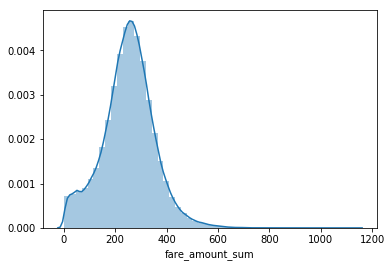

In [69]:
## ---------------------------------------------------------------------
## Null imputation
## ---------------------------------------------------------------------
data = df.copy()

## Menghitung Nilai Null
df_cnt = data.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)

## Mengambil column dengan Null lebih dari 20% kecuali n tahun restruk
feat_null = df_cnt[df_cnt>=0.2].index.tolist()
feat_null = [x for x in feat_null if not(x in [
 'fare_amount_sum'
])]

## Membuang Kolom data dengan Null lebih dari 20%
lcol = data.columns.values
lcol = [x for x in lcol if not(x in feat_null)]
data = data.loc[:,lcol].reset_index(drop=True)

## Cek kolom data
tmp = data.apply(lambda x: x.count(), axis=0)
tmp = [tmp.index[i] for i in range(len(tmp)) if tmp[i]<data.shape[0]]

## Kolom identitas
exc_col = []
exc_col = np.append(exc_col,[
 'fare_amount_sum'
])

## Missing Values Handling selain kolom identitas
for col in data.columns.values:
    if not(col in exc_col):
#         print(col)
        ds = data[col]
        typ = ds.dtype
        ## Ganti dengan modus untuk object dan categorical
        if typ==object:
            ds = ds.fillna(ds.mode()[0])
        elif type(typ)==pd.core.dtypes.dtypes.CategoricalDtype:
            ds = ds.fillna(ds.mode()[0])
        ## Untuk numeric ganti dengan median
        else:
            ds = ds.fillna(ds.median())
        data[col] = ds
        

### Data minus jadi 0
#for col in data.columns.values[M:N+1]:
#  data[col] = data[col].map(lambda x: x if x>0 else 0)
#data = data.reset_index(drop=True)

# target_count = data['fare_amount_sum'].value_counts()
# print('Class 0:', target_count[0])
# print('Class 1:', target_count[1])
# print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
# target_count.plot(kind='bar', title='Count (TARGET)');

sns.distplot(data['fare_amount_sum'])

df = data.copy()

In [70]:
## Menghitung Nilai Null
df_cnt = df.count()
df_cnt = df_cnt.map(lambda x: 1.0-(x*1.0/df.shape[0]))
df_cnt.sort_values(ascending=False,inplace=True)
df_cnt

work_time_in_secs               0.0
pickup_hour_11                  0.0
pickup_hour_9                   0.0
pickup_hour_8                   0.0
pickup_hour_7                   0.0
pickup_hour_6                   0.0
pickup_hour_5                   0.0
pickup_hour_4                   0.0
pickup_hour_3                   0.0
pickup_hour_2                   0.0
pickup_hour_1                   0.0
pickup_hour_0                   0.0
pickup_to_dropoff_local_set     0.0
pickup_to_dropoff_local_list    0.0
surcharge_count                 0.0
surcharge_sum                   0.0
tip_amount_count                0.0
tip_amount_sum                  0.0
fare_amount_sum                 0.0
dropoff_latitude_max            0.0
dropoff_longitude_max           0.0
dropoff_latitude_min            0.0
dropoff_longitude_min           0.0
pickup_latitude_max             0.0
pickup_longitude_max            0.0
pickup_latitude_min             0.0
pickup_longitude_min            0.0
passenger_count_max         

In [71]:
df.dtypes

hack_license                     object
trip_num                          int32
passenger_count_min               int32
passenger_count_median            int32
passenger_count_max               int32
pickup_longitude_min            float64
pickup_latitude_min             float64
pickup_longitude_max            float64
pickup_latitude_max             float64
dropoff_longitude_min           float64
dropoff_latitude_min            float64
dropoff_longitude_max           float64
dropoff_latitude_max            float64
fare_amount_sum                 float64
tip_amount_sum                  float64
tip_amount_count                  int32
surcharge_sum                   float64
surcharge_count                   int32
pickup_to_dropoff_local_list     object
pickup_to_dropoff_local_set      object
pickup_hour_0                     int32
pickup_hour_1                     int32
pickup_hour_2                     int32
pickup_hour_3                     int32
pickup_hour_4                     int32


In [72]:
df['pickup_to_dropoff_local_set'] = df['pickup_to_dropoff_local_set'].map(lambda x: ','.join(np.sort(x.replace('[','').replace(']','').replace(', ',',').split(',')).tolist()))


In [74]:
target_var = 'fare_amount_sum'
dtype = df.dtypes.drop(['hack_license','pickup_to_dropoff_local_list']+[target_var])
list_col = dtype.index.values.tolist()

X = df.loc[:, list_col]
Y = df[target_var]

In [76]:
list_col_cat = [x for x in X.columns.values if ((X[x].dtypes==object) or (type(X[x].dtypes)==pd.core.dtypes.dtypes.CategoricalDtype))]
list_idx_cat = [i for i in range(len(X.columns.values)) if X.columns.values[i] in list_col_cat]

# Label Encoding
le = labelEnc(categorical_features=list_idx_cat)
le.fit(X)
categorical_feat_classes = le.categorical_feat_classes

### One Hot Encoding
onehotenc = oneHotEnc(categorical_features=list_idx_cat, fit_onehot=OneHotEncoder())

### Feature scaling
scaler = StandardScaler()

### Merge preprocess pipeline
X_1 = le.transform(X)
# X_train1 = le.transform(X_train)
# X_test1 = le.transform(X_test)

# Preprocessing
pipeline = [
  # ('label_enc', le),
  ('one_hot_enc', onehotenc),
  #  ('scale', scaler),
  #  ('feature_selection', selector)
]
pipeline_preprocess = Pipeline(pipeline)
pipeline_preprocess.fit(X_1, Y)

# Get colname of new dataset features
onehotenc = pipeline_preprocess.steps[0][1]
categorical_onehot_idx = onehotenc.enc.feature_indices_
categorical_onehot_nval = onehotenc.enc.n_values_
colname = []
k=0
for i in categorical_onehot_idx[:-1]:
  feat = list_col_cat[k]
  for j in range(categorical_onehot_nval[k]):
    val = categorical_feat_classes[list_idx_cat[k]][j]
    colname.append("{}_{}".format(feat,val))
  k+=1
lcol_num = [x for x in dtype.index.values if not(x in list_col_cat)]
for i in lcol_num:
  colname.append("{}".format(i))

X_1 = pipeline_preprocess.transform(X_1)
# X_train1 = pipeline_preprocess.transform(X_train1)
# X_test1 = pipeline_preprocess.transform(X_test1)

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/sklearn/ut

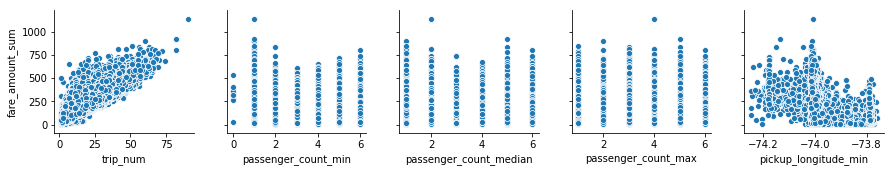

In [80]:
pp = sns.pairplot(data=df, y_vars=['fare_amount_sum'], x_vars=list_col[0:5])

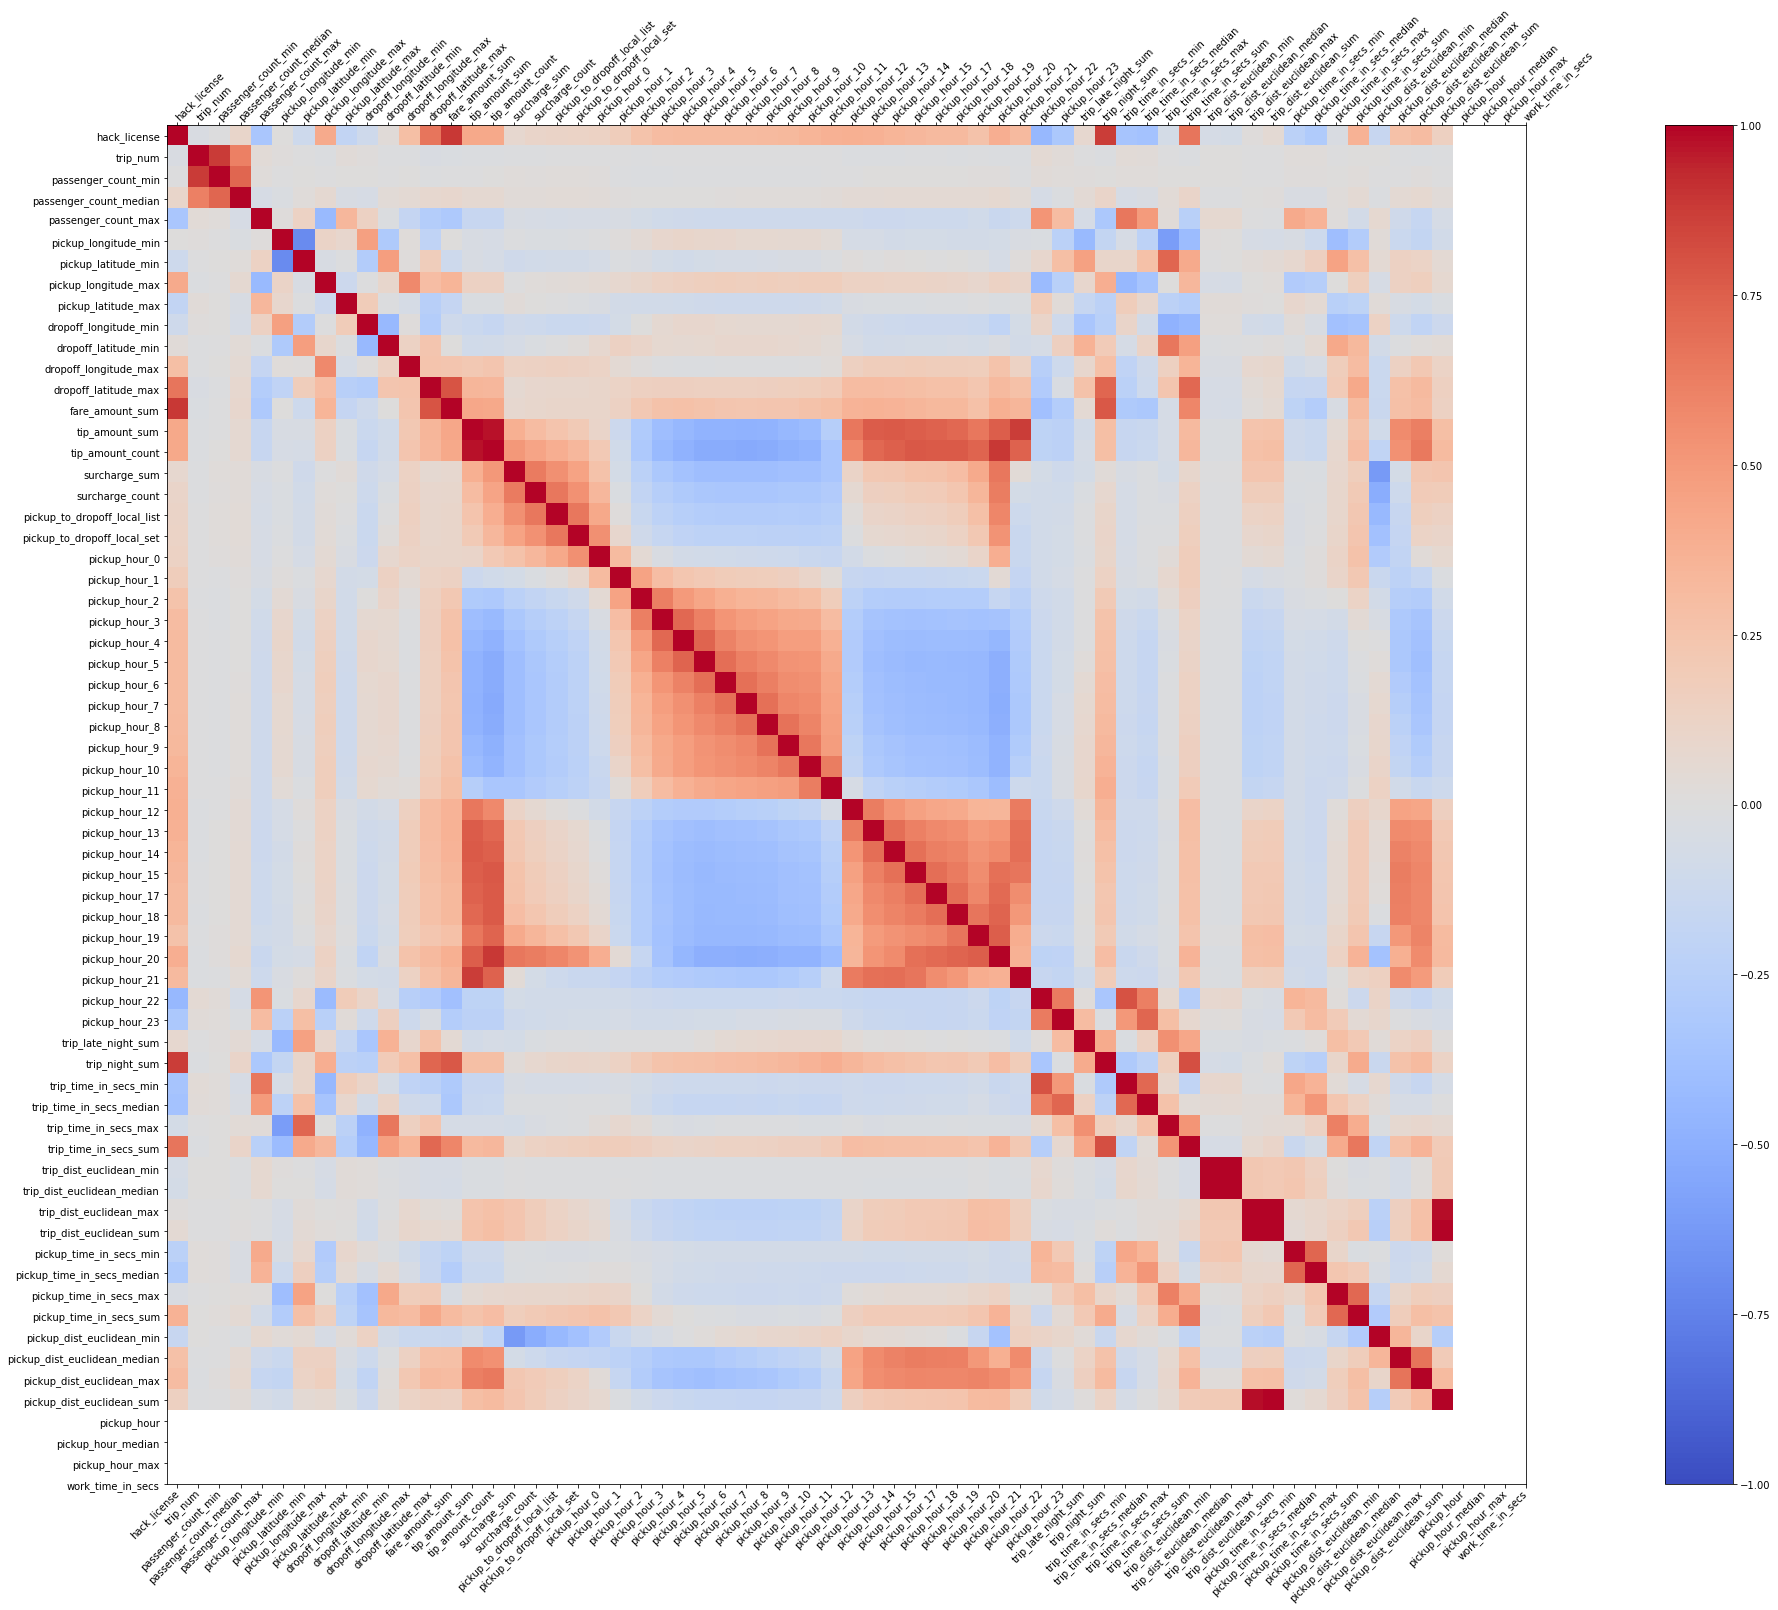

In [125]:
corr = X.corr()
fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

# ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
# ax.set_yticklabels(ax.get_yticklabels(),rotation=60)

mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

plt.show()
# plt.savefig('filename.png')

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y, test_size=0.3, random_state=100)
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [84]:
### Resampling unbalanced dataset
# (1) Over-sampling with SMOTE
# def_ratio = 0.09
# sm = SMOTE(random_state=42, ratio={0:Y_train.value_counts()[0],1:int(Y_train.value_counts()[0]*(def_ratio/(1-def_ratio)))})
# sm.fit(X_train,Y_train)
# X_train_upsampled, Y_train_upsampled = sm.sample(X_train, Y_train)

X_train_upsampled = X_train
Y_train_upsampled = Y_train

In [85]:
dtrain = xgb.DMatrix(X_train_upsampled, label=Y_train_upsampled)
dtest  = xgb.DMatrix(X_test , label=Y_test )

/home/arditto_trianggada3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [107]:
K = 3
kf = KFold(n_splits = K, random_state = 3228, shuffle = True)

In [108]:
xgb_preds = []
bst = bst_models(colname=colname,score_method="mean")

In [109]:
def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = 1 - (sum((labels-preds )**2)/sum((labels-np.mean(labels))**2))
    return 'r2',r2

In [110]:
for train_index, test_index in kf.split(X_train_upsampled):
    train = X_train_upsampled; target_train = Y_train_upsampled
    train_X, valid_X = train[train_index], train[test_index]
    train_y, valid_y = target_train[train_index], target_train[test_index]
    
    # Create logistic regression object
    d_train = xgb.DMatrix(train_X, label=train_y,feature_names=colname)
    d_valid = xgb.DMatrix(valid_X, label=valid_y,feature_names=colname)

    xgb_params = {
        'eta': 0.03,
        'max_depth': 4,
        'subsample': 0.75,
        'objective': 'reg:linear',
        'silent': 1,
        'colsample_bytree': 0.8,
        'eval_metric': ['rmse']
    }
    early_stopping = 80
    num_round = 400
    evallist  = [(d_train,'train'), (d_valid,'eval')]
    
    model = xgb.train(
      xgb_params, 
      d_train, 
      num_round,
      evallist,
      feval=r2_metric,
      early_stopping_rounds=early_stopping
    )
    bst.add_model(model)

[0]	train-rmse:262.154	eval-rmse:261.834	train-r2:-5.75922	eval-r2:-5.76712
Multiple eval metrics have been passed: 'eval-r2' will be used for early stopping.

Will train until eval-r2 hasn't improved in 80 rounds.
[1]	train-rmse:254.38	eval-rmse:254.061	train-r2:-5.36432	eval-r2:-5.37134
[2]	train-rmse:246.871	eval-rmse:246.567	train-r2:-4.99411	eval-r2:-5.00098
[3]	train-rmse:239.555	eval-rmse:239.246	train-r2:-4.64411	eval-r2:-4.6499
[4]	train-rmse:232.46	eval-rmse:232.15	train-r2:-4.31474	eval-r2:-4.31973
[5]	train-rmse:225.58	eval-rmse:225.278	train-r2:-4.00481	eval-r2:-4.00948
[6]	train-rmse:218.939	eval-rmse:218.652	train-r2:-3.71444	eval-r2:-3.71912
[7]	train-rmse:212.59	eval-rmse:212.311	train-r2:-3.44497	eval-r2:-3.44936
[8]	train-rmse:206.303	eval-rmse:206.027	train-r2:-3.18596	eval-r2:-3.18987
[9]	train-rmse:200.205	eval-rmse:199.929	train-r2:-2.94217	eval-r2:-2.94553
[10]	train-rmse:194.315	eval-rmse:194.057	train-r2:-2.71362	eval-r2:-2.71718
[11]	train-rmse:188.58	eval-rm

In [111]:
# Predict testing data
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)

In [112]:
compare = {
  'train': pd.DataFrame({'true':Y_train,'pred':y_train_pred}),
  'test': pd.DataFrame({'true':Y_test,'pred':y_test_pred})
}

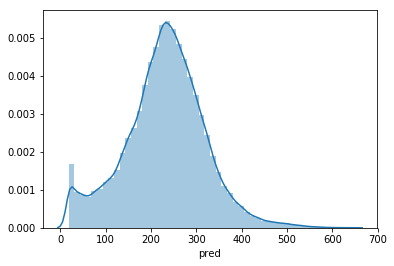

In [113]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

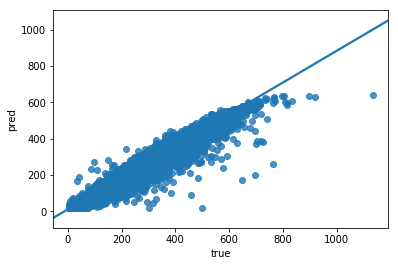

In [115]:
# Model evaluation: KS
test_compare = compare['train']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)

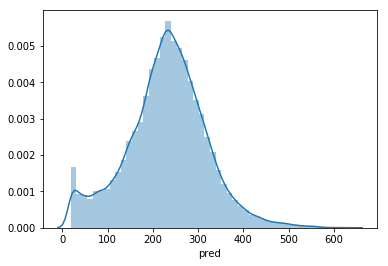

In [114]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
sns.distplot(a=disp.loc[:,'pred'], hist=True)

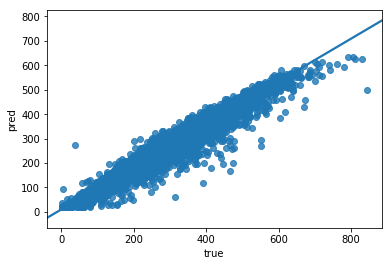

In [116]:
# Model evaluation: KS
test_compare = compare['test']
N = test_compare.shape[0]
listidx = random.sample(test_compare.index.values.tolist(),  N)
disp = test_compare.loc[listidx,:]
ax = sns.regplot(x="true", y="pred", data=disp)

In [117]:
df.fare_amount_sum.describe()

count    167621.000000
mean        251.077805
std         100.774103
min           2.500000
25%         192.000000
50%         254.000000
75%         312.000000
max        1135.000000
Name: fare_amount_sum, dtype: float64

In [122]:
print("RMSE: {}".format(np.sqrt(mean_squared_error(Y_test,y_test_pred))))
print("R2  : {}".format(r2_score(Y_test,y_test_pred)))

RMSE: 28.320376076951305
R2  : 0.9210229406531033


In [123]:
for i,mdl in enumerate(bst.model):
    print("Model:{}".format(i))
    print(pd.Series(mdl.get_fscore()).sort_values(ascending=False))

Model:0
trip_dist_euclidean_sum       434
trip_time_in_secs_sum         379
trip_num                      118
trip_dist_euclidean_min        79
dropoff_longitude_min          66
tip_amount_sum                 40
pickup_dist_euclidean_sum      32
trip_time_in_secs_min          19
work_time_in_secs              18
pickup_longitude_min           14
trip_dist_euclidean_max         5
trip_dist_euclidean_median      4
trip_time_in_secs_max           2
tip_amount_count                2
pickup_hour_11                  1
pickup_hour_14                  1
pickup_dist_euclidean_max       1
dtype: int64
Model:1
trip_dist_euclidean_sum         426
trip_time_in_secs_sum           357
trip_num                        145
trip_dist_euclidean_min          78
dropoff_longitude_min            64
tip_amount_sum                   49
pickup_dist_euclidean_sum        36
trip_time_in_secs_min            18
work_time_in_secs                18
pickup_longitude_min             12
trip_dist_euclidean_max          

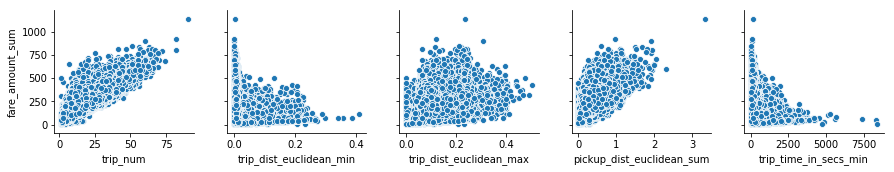

In [127]:
pp = sns.pairplot(data=df, y_vars=['fare_amount_sum'], x_vars=['trip_num','trip_dist_euclidean_min','trip_dist_euclidean_max','pickup_dist_euclidean_sum','trip_time_in_secs_min'])